In [1]:
import os
import numpy as np
import numpy.random as rnd
import matplotlib.pyplot as plt
import scipy.stats as ss
os.environ["KERAS_BACKEND"] = "torch"
import keras

# Under construction
<font color="red"><b>Author: Wim R.M. Cardoen (wcardoen@gmail.com)</b></font><br>
If you stumble by chance on this website and find errors, have comments/suggestions,<br> please send 
an email to the author! Thanks.<br>

# Hands-on Introduction to Deep Learning (Lecture 2)

## Synopsis  
In <a href="./lecture1.ipynb"><b>Lecture 1</b></a>, we worked out the details of <font color="green"><b>logistic regression</b></font> as
the simplest neural net.<br>
We introduced the following concepts:
* **neuron** (`perceptron`)
* **activation function** (`sigmoid`)
* **loss function** (metric to optimize the neural net) for `binary classification`
* **gradient descent method** (`optimization` of the weights and biases)
* **forward propagation** (moving forward from the input to the loss function)
* **backward propagation** (moving backwards from the loss function to the inputs to calculate the gradients)

## Goal
In this Lecture, we will generalize the previous example to a <font color="green"><b>fully connected dense neural net</b></font>.

## Note
* At the end of some paragraphs you may find a section "<font color="teal"><b>Note (for sake of completeness)</b>"</font><br>
* I have added a few additional <font color="orange"><b>notebooks</b></font>, such as
  - <a href="./ewma.ipynb"><b>ewma.ipynb</b></a>
  - <a href="./bias-variance.ipynb"><b>bias-variance.ipynb</b></a>
  - <a href="./finitediff.ipynb"><b>finitediff.ipynb</b></a>
  
  to elucidate on certain topics.
* These sections and notebooks can be <font color="teal"><b>skipped</b></font>. They target people who want to dig deeper<br>
(in case you want to implement your own deep learning code from scratch in e.g. <a href="https://cupy.dev/"><b>CuPy</b></a> or a compiled language).

# 1.Dense Neural Nets

## Definitions:
A **fully connected dense neural network** of <font color="green"><b>depth</b></font> $L$ is a neural net where:
- <font color="green"><b>every neuron</b></font> in layer ($l$) is connected to <font color="green"><b>every</b></font> neuron in layer ($l+1$) where $l=\{0,1,2,\ldots,L-1\}$.
- these connections are **directed** and **acyclic** (<a href="https://en.wikipedia.org/wiki/Directed_acyclic_graph"><b>DAG</b></a>), i.e. they are unidirectional from layer $l$ towards layer $l+1$ and do
  **NOT** cycle back.
- the number of nodes in layer $l$ (<font color="green"><b>width</b></font> of layer $l$) will be designated as $n^{[l]}$.
- types of layers:
  + <font color="green"><b>input</b></font> layer: $l=0$. It is **NOT** counted as a real layer (this will become obvious soon!). 
  + <font color="green"><b>output</b></font> layer: $l=L$.
  + <font color="green"><b>hidden</b></font> layers: $l \in \{1,2,\ldots,L-1\}$.

Neural nets with <font color="green"><b>NO hidden</b></font> layers ($L=1$) are called 
<font color="green"><b>shallow</b></font>.<br> The neural net we discussed previously (Lecture 1) is an example of a shallow neural net with $n^{[0]}=2$ and $n^{[1]}=1$.


## Example:
The image below displays a deep neural with $L=4$ layers (neural net of depth 4).

<img src="dnn_4layers.jpeg" alt="Deep neural net with 4 layers" style="width:65%; height:auto">

* <font color="green"><b>input</b></font> layer: layer $0$
  + the input layer requires input vectors/examples each of length $n^{[0]}=6$
* <font color="mediumslateblue"><b>hidden</b></font> layers: layers $1,2,3$
  + layer $1$: has $4$ nodes ($n^{[1]}=4$)
  + layer $2$: has $3$ nodes ($n^{[2]}=3$)
  + layer $3$: has $6$ nodes ($n^{[3]}=6$)
* <font color="red"><b>output</b></font> layer: layer $4$
  + layer $4$: has $4$ nodes ($n^{[4]}=4$)

The output layer is followed by a <font color="green"><b>loss function</b></font> which is 
the <font color="green"><b>objective function</b></font> to be minimized during the <font color="green"><b>training</b></font> phase.

<font color="teal"><b>Note (for sake of completeness)</b></font><br>
<details>
  <summary>Click here to expand!</summary>
    
There are exceptions to the aforementioned definition, e.g. to name a few:
+ <a href="https://en.wikipedia.org/wiki/Residual_neural_network"><b>Residual Neural Networks</b></a> (ResNets)
+ <a href="https://en.wikipedia.org/wiki/Bidirectional_recurrent_neural_networks"><b>Bidirectional Recurrent Neural Networks</b></a> (BRNNs)
+ $\ldots$
 
This type of networks will **NOT** be covered in this lecture but may the subject of future talks.

</details>

# 2.Activation functions
Previously, we discussed the `sigmoid` activation function:<br>
  $\begin{eqnarray}
     \sigma(z) & = & \frac{1}{1\,+\,\exp(-z)}\,, z \,\in \mathbb{R}
  \end{eqnarray}$

The activation functions for the output layer and the hidden layers
are in general <font color="green"><b>different</b></font>.

- <font color="red"><b>output</b></font> layer:<br>the activation function is <font color="green"><b>determined</b></font> by the subsequent loss function.
  * `binary` classification: <br>
    + `sigmoid` $\sigma(z)$
    + $\sigma(z) \in [0,1]$
  * `multiclass` classification: 
    + $\begin{eqnarray}
       \texttt{softmax}(z_{ij}) & := &  \frac{\exp(z_{ij})}{ \displaystyle\sum_{k=1}^C \exp(z_{ik})}
        \end{eqnarray}$
    + $C$ stands for the number of classes 
    + $\texttt{softmax}(z_{ij}) \in [0,1]$  
  * `linear regression`:<br>
    + `1` (no action) 

- <font color="mediumslateblue"><b>hidden</b></font> layers:<br>
  There are several activation functions that are commonly used:
  * $\texttt{relu}(x)$: (**Re**ctified **L**inear **U**nit) - the most commonly used<br>
    + $\texttt{relu}(x) := \max(0,x)$
    + $\texttt{relu}(x) \geq 0 $
  * $\texttt{lrelu}(x;\alpha)$: (**L**eaky **Re**ctified **L**inear **U**nit)<br>
    + $\texttt{lrelu}(x;\alpha) := \max(\alpha x, x) \,,\,0 \leq \alpha < 1$
  * $\texttt{gelu}(x)$: (**G**aussian-**e**rror **Linear** **U**nit)<br>
    + $\begin{eqnarray} \texttt{gelu}(x) &:= & x\,\Phi(x) \end{eqnarray}$ <br>
      where $\Phi(x)$ stands for the <a href="https://en.wikipedia.org/wiki/Cumulative_distribution_function"><b>CDF</b></a> of the standard normal distribution.
    + $\begin{eqnarray} \texttt{gelu}(x)              & = &x \displaystyle\int_{-\infty}^x \frac{1}{\sqrt{2 \pi}}{ \exp\bigg(-\frac{t^2}{2}\bigg)} dt
       \end{eqnarray}$
  * $\texttt{swish}(x;\beta) := x \, \sigma(\beta x)$    
  * $\texttt{tanh}(x)$: (Hyperbolic Tangent)<br>
    + $\texttt{tanh}(x) := \displaystyle \frac{\exp(x) - \exp(-x)}{\exp(x) + \exp(-x)}$
    + $\texttt{tanh}(x) \in [-1,1]$
  * $\ldots$  <br>
  

## Plot of some of the activation functions
Below you will find some of the aforementioned activation functions displayed.

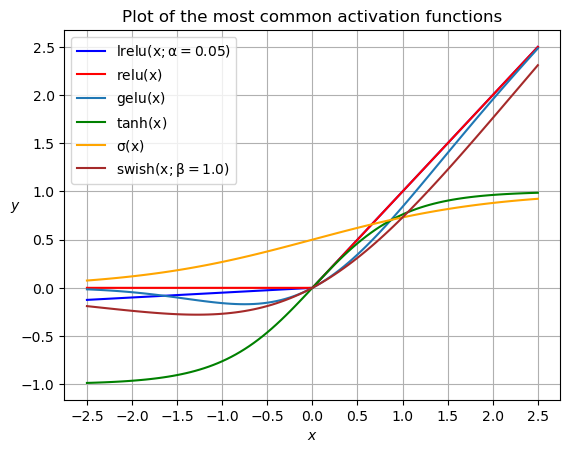

In [4]:
START= -2.5
END= 2.5
DENS_PER_UNIT=20
ALPHA=0.05
x = np.linspace(start=START,stop=END, num=int((END-START))*DENS_PER_UNIT+1)
y_relu = np.maximum(0,x)
y_lrelu = np.maximum(ALPHA*x,x)
y_tanh = np.tanh(x)
y_sigmoid = 1.0/(1.0+np.exp(-x))
y_swish = x*y_sigmoid
y_gelu = x* ss.norm.cdf(x)
plt.title(r"Plot of the most common activation functions")
plt.plot(x,y_lrelu, label=r"$\mathrm{lrelu(x;\alpha=0.05)}$", color="blue")
plt.plot(x,y_relu, label=r"$\mathrm{relu(x)}$", color="red")
plt.plot(x,y_gelu, label=r"$\mathrm{gelu(x)}$")
plt.plot(x,y_tanh, label=r"$\mathrm{tanh(x)}$", color="green")
plt.plot(x,y_sigmoid, label=r"$\mathrm{\sigma(x)}$", color="orange")
plt.plot(x,y_swish, label=r"$\mathrm{swish(x;\beta=1.0)}$", color="brown")
plt.xticks(np.arange(START,END+0.5, step=0.5))
plt.xlabel(r"$x$")
plt.ylabel(r"$y$",rotation=0)
plt.grid()
plt.legend()
plt.show()

# 3.Cost/Loss functions

* The <font color="green"><b>cost</b></font> function ($\mathcal{C}$) is defined as follows:<br>
$\begin{eqnarray}
    \mathcal{C} & := & \frac{1}{m} \sum_{i=1}^m \mathcal{L}^{(i)}
 \end{eqnarray}$<br>
 where $\mathcal{L}^{(i)}$ stands for the <font color="green"><b>loss</b></font> function for example $i$ and $m$ stands for the batch
 of examples used.

* Depending on the task we want to accomplish, we need to use different loss functions.<br>
  The most <font color="blue"><b>common</b></font> loss functions are:<br>
  * `binary classification`<br>
    $\begin{eqnarray}
        \mathcal{L}^{(i)} &:= & -y_i\,\log(a^{[L]}_i)
      \end{eqnarray}$<br>
    where:
    - $y_i$ is either $0$ or (<font color="red"><b>exclusive</b></font>) $1$ and represents the label of example $i$.
  * `multiclass classification` (exclusionary)<br>
    $\begin{eqnarray}
        \mathcal{L}^{(i)} &:= & \sum_{j=1}^C -y_{ij}\,\log(a^{[L]}_{ij})
      \end{eqnarray}$<br>
    where:<br>
    + $y_i$ is a <a href="https://en.wikipedia.org/wiki/One-hot"><b>one-hot</b></a> encoding vector representing the <font color="green"><b>label</b></font> of example $i$.
    + $C$ stands for the <font color="green"><b>number of classes</b></font>.
  * `linear regression`<br>
    $\begin{eqnarray}
        \mathcal{L}^{(i)} &:= \frac{1}{2} (y_i - a^{[L]}_i)^2
      \end{eqnarray}$<br>
    where:<br>
    + $y_i$ is the value associated with example $i$.
* The cost function can also contain extra terms (i.e. <font color="green"><b>regularization</b></font>) to constrain certain parameters/prevent <font color="green"><b>overfitting</b></font>.<br>
  We will elaborate on this later on in this Lecture.


<font color="teal"><b>Note (for sake of completeness)</b></font><br>
<details>
  <summary>Click here to expand!</summary>

- A lot of loss functions can be easily derived using:
  + the <a href="https://en.wikipedia.org/wiki/Maximum_likelihood_estimation"><b>Maximum Likelihood Estimation</b></a> (MLE) method or using the <a href="https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence"><b>Kullback-Leibler divergence</b></a>
  + combined with the theory of <a href="https://en.wikipedia.org/wiki/Generalized_linear_model"><b>Generalized Linear Models</b></a> (GLM).<br>
  e.g. `Poisson loss function` (to predict discrete counts),...
- To improve <font color="green"><b>numerical stabilty</b></font>, the activation function for the
    last layer ($L$) and the loss function are:
  + often <font color="green"><b>calculated together/at once</b></font>
  + and then bear a separate (information-theoretic) name.

- In the output layer there can be several types of activation functions at the same time,<br>
  e.g. a `linear regression` problem where we are interested at the same time:
  + in a predicted value of $a^{[L]}_{i1} \in \mathbb{R}$
  + the prediction of the variance ($ a^{[L]}_{i2}\in \mathbb{R}^+$)

</details>

# 4.Structure of the DNN: summary
- We just described the <font color="green"><b>basic structure</b></font> of a deep neural network, i.e.:
  + the layers $l \in \{0,1,\ldots, L\}$.
  + the number of nodes per layer i.e. $n^{[l]}$ for $l \in \{0,1,\ldots, L\}$.
- We also introduced the two other structural components:
  + activation functions.<br>
    <font color="green"><b>ONE</B></font> activation function ($\widehat{h}^{[l]}$) is <font color="green"><b>REQUIRED</b></font> per layer $l \in \{1,\ldots, L\}$.
  + the loss/cost function $\mathcal{L}^{(i)}/\mathcal{C}$.<br>
    The loss/cost function is only <font color="green"><b>MANDATORY</b></font> during training.

## Implementation of the previous DNN example in Keras/PyTorch

We have a deep neural with $L=4$ layers (neural net of depth 4).
* <font color="green"><b>input</b></font> layer: layer $0$
  + the input layer requires input vectors/examples each of length $n^{[0]}=6$
* <font color="mediumslateblue"><b>hidden</b></font> layers: layers $1,2,3$
  + layer $1$: has $4$ nodes ($n^{[1]}=4$) - activation $h^{[1]}$: `ReLu` 
  + layer $2$: has $3$ nodes ($n^{[2]}=3$) - activation $h^{[2]}$: `ReLu`
  + layer $3$: has $6$ nodes ($n^{[3]}=6$) - activation $h^{[3]}$: `ReLu` 
* <font color="red"><b>output</b></font> layer: layer $4$
  + layer $4$: has $4$ nodes ($n^{[4]}=4$) - activation $h^{[4]}$: `softmax`
    (We assume that the model will train to classify $4$ classes). 

In [44]:
## Keras/PyTorch code
model = keras.Sequential([
          keras.layers.Input(shape=(6,)),                      # Input: 6-dimensional input vector
          keras.layers.Dense(units=4, activation='relu'),      # Layer 1
          keras.layers.Dense(units=3, activation='relu'),      # Layer 2
          keras.layers.Dense(units=6, activation='relu'),      # Layer 3
          keras.layers.Dense(units=4, activation='softmax')])  # Output layer: 4 classes
print(model.summary())  

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 4)              │            28 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │            15 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 6)              │            24 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 4)              │            28 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 95 (380.00 B)

 Trainable params: 95 (380.00 B)

 Non-trainable params: 0 (0.00 B)

None


## <font color="blue"><b>Here comes an exercise</b></font>
Add also the low level version (PyTorch without Keras)

# 5. Training of a Deep Neural Network

During <font color="green"><b>TRAINING</b></font>, a `function` needs to be found<br>
which is able to <font color="green"><b>GENERALIZE</b></font> well (i.e. to deal sufficiently well with unseen examples).

Therefore, two questions arise:
1. does such a `function` even exist?
2. and if so, how to find such a `function`/how to train a network.<br>

## 1. The universal approximation theorems (UATs)
<font color="green"><b>Theorem</b></font>:<br>
A feedforward neural network with:
1. at least one hidden layer
2. a finite number of neurons
3. a nonlinear activation function

can approximate to any accuracy<br>
<font color="green"><b>any continuous function</b></font> on a <font color="green"><b>compact subset</b></font> of $\mathbb{R}^n$.

This theorem is related to the <font color="green"><b>Stone-Weierstrass theorem</b></font> from analysis<br> (see e.g. <a href="https://david92jackson.neocities.org/images/Principles_of_Mathematical_Analysis-Rudin.pdf"><b>Principles of Mathematical Analysis by Walter Rudin</b></a>)

Sources:
* <a href="https://web.njit.edu/~usman/courses/cs675_fall18/10.1.1.441.7873.pdf">Cybenko, G. (1989). Approximation by superposition of sigmodial functions. Mathematics of Control, Signals and Systems, 2(4), p. 303-314.</a>
* <a href="https://web.njit.edu/~usman/courses/cs677/hornik-nn-1991.pdf"> Hornik, K. (1991). Approximation Capabilities of Multilayer Feedforward Networks. Neural Networks, 4, p. 251-257.</a>

## 2.Training a deep neural network.

- In <a href="./lecture1.ipynb"><b>Lecture 1</b></a>, we trained a shallow neural network ($1$ node in $1$ layer).<br>
  To do so, we had to <font color="green"><b>iterate</b></font> repeatedly over the <font color="blue"><b>following loop</b></font>:
  + Perform the <font color="green"><b>forward propagation</b></font></color>.<br>Start at the input layer and proceed forward to the output layer and the loss function.
  + Perform the <font color="green"><b>backward propagation</b></font></color>.<br>Start at the loss function and recede all the way to the first layer
    in order<br> to obtain the <font color="green"><b>gradients of the parameters</b></font>.
  + <font color="green"><b>Update the parameters</b></font> (weights and bias) using the <font color="green"><b>gradient descent</b></font> method.<br>  


- In the following sections, we will elaborate on the same components for a deep neural net.

# 6.Forward propagation (dense deep neural net)

We extracted a slice from the previous example to illuminate the principle of forward propagation .<br><br>
<img src="forward1.jpeg" alt="Connections between layers 1 and 2" style="width:65%; height:auto"><br>

**Setup/Context**
- We have a dense deep neural net with **$L$** layers. Each layer $l$ has **$n^{[l]}$** nodes.
- The input layer ($l=0$) has $n^{[0]}$ nodes.<br>
- The number of nodes ($n^{[0]}$) is **equal** to the dimensionality of each input vector $x_i$, where:<br>
  $\begin{eqnarray}
    x_i := \begin{pmatrix}
            x_{i,1} & x_{i,2} & \ldots & x_{i,n^{[0]}}
           \end{pmatrix}
  \end{eqnarray}$<br>
- $ a^{[0]}_{i} := x_i $   

**Transformation**
- At <font color="green"><b>layer</b></font> $l \in \{1,2,\ldots,L\}$ the vector associated with example $i$ is transformed as follows:<br>
    $\begin{eqnarray}
      z^{[l]}_{i,k} &= & \sum_{j=1}^{n^{[l-1]}} a^{[l-1]}_{i,j} w^{[l]}_{j,k} + b^{[l]}_k \; \;,\; k \in \{1,2, \dots,n^{[l]}\} \\
      a^{[l]}_{i,k} &= & \widehat{h}^{[l]}(z^{[l]}_{i,k}) \; \;,\; k \in \{1,2, \dots,n^{[l]}\}
    \end{eqnarray}$<br>
  i.e.:
    + at **each** node $k$ of layer $l$ the input vector $a^{[l-1]}_i$ is <font color="green"><b>weighted</b></font> and a <font color="green"><b>bias</b></font> is added ($ \Rightarrow z^{[l]}_{i,k}$)
    + subsequently, at **each** node $k$ of layer $l$ the corresponding value $z^{[l]}_{i,k}$ is <font color="green"><b>transformed</b></font> using a **non-linear** activation function
      $\widehat{h}^{[l]}$.<br> The output of the activation function for example $i$ at node $k$ of layer $l$ is labeled $a^{[l]}_{i,k}$.<br>
    + given that the $l$-th layer contains $n^{[l]}$
      nodes, the transformation of example $i$ at layer $l$ results into a vector of dimension $n^{[l]}$.

**Vectorized Form**   
- This procedure can easily be <font color="green"><b>vectorized</b></font>:<br> $m$ example vectors can be transformed simultaneously/in batch at the same layer .

- <font color="green"><b>Algorithm</b></font>:
  + Let $X$ be an input matrix of $m$ examples (one example per row) and $n^{[0]}$ columns.
  + $A^{[0]}:=X$ $,\hspace{0.5in}A{[0]} \in \mathbb{R}^{m\times n^{[0]}}$<br>
    $\texttt{for(l=1,..,L)}$<br>
    $\texttt{do}$<br>
    $\begin{eqnarray}
      \hspace{0.35in}Z^{[l]} &= & A^{[l-1]}W^{[l]} + b^{[l]} \\
      A^{[l]} &= &\widehat{h}^{[l]}(Z^{[l]})
     \end{eqnarray}$<br>
    $\texttt{done}$
  + Calculate $\mathcal{C}$ using $A^{[L]}$ and $Y$.

**Summary**   
- In order to learn, the network requires weight, biases matrices and activation functions for each layer $l$:  
  * <font color="green"><b>Weight matrices</b></font>: $W^{[l]} \in \mathbb{R}^{n^{[l-1]}\times n^{[l]}}$
  * <font color="green"><b>Bias vectors</b></font>: $b^{[l]} \in \mathbb{R}^{ 1 \times n^{[l]}}$
  * <font color="green"><b>Non-linear activation functions</b></font>: $\widehat{h}^{[l]}$
- The weight matrices and the bias vectors are known as the <font color="green"><b>PARAMETERS</b></font> of the model.

# 7.Back propagation

The <font color="green"><b>back propagation</b></font> operates in the <font color="green"><b> opposite</b></font> direction of the forward propagation:
  - it starts with the cost function $\mathcal{C}$ and recedes all the way back to $l=1$.
  - during the back propagation, the <font color="green"><b>gradients</b></font> of the parameters $W^{[l]}, b^{[l]}$ are calculated.


<font color="teal"><b>Note (for sake of completeness)</b></font><br>
<details>
  <summary>Click here to expand!</summary>

In these section we will describe the backpropagation in more detail.<br>The expressions below can easily
be derived by the application of the chain rule.

- We start at the <font color="green"><b>output</b></font> layer ($l=L$):
  * $\begin{eqnarray}
     \mathcal{C} & := & \frac{1}{m} \sum_{i=1}^m \mathcal{L}^{(i)}
     \end{eqnarray}$
  * Let:<br>
    $\begin{eqnarray}
     (dA^{[L]})_{ij} &:=& \frac{\partial \mathcal{L}^{(i)}} {\partial a^{[L]}_{i,j}} \\
     (dZ^{[L]})_{ij} &:=& \frac{\partial \mathcal{L}^{(i)}} {\partial z^{[L]}_{i,j}} &= &\sum_{k=1}^{n^{[L]}}\frac{\partial \mathcal{L}^{(i)}} {\partial a^{[L]}_{i,k}} \frac{\partial a^{[L]}_{i,k}}
     {\partial z^{[L]}_{i,j}}\\
     (dW^{[L]})_{i,j} & := &  \frac{\partial \mathcal{C}}{\partial w^{[L]}_{i, j}} \\
     (db^{[L]})_{j} & := &  \frac{\partial \mathcal{C}}{\partial b^{[L]}_{j}} 
    \end{eqnarray}$
  * The application of the <font color="green"><b>chain rule</b></font> results into:<br>
    $\begin{eqnarray}
     dW^{[L]} & = & \frac{1}{m}(A^{[L-1]})^T.dZ^{[L]} \\
     db^{[L]} & = & \frac{1}{m}\sum_{i=1}^m(dZ^{[L]})_i 
    \end{eqnarray}$
  
- Using the relation $Z^{[l]} = A^{[l-1]}.W^{[l]} + b^{[l]}$<br>
  we can determine $dW^{[l]}, db^{[l]}$ for the <font color="green"><b>other layers</b></font> $ l \in \{L-1,\ldots,2,1\}$.

  Therefore,<br>
  $\texttt{for(l=L,...,2)}$<br>
  $\texttt{do}$<br>
  $\begin{eqnarray}
      \hspace{0.35in}dA^{[l-1]} &= & dZ^{[l]}.(W^{[l]})^T \\
                     dZ^{[l-1]} &= & dA^{[l-1]} \odot d\widehat{H}^{[l-1]} \\
                     dW^{[l-1]} & =& \frac{1}{m}(A^{[l-2]})^T.dZ^{[l-1]} \\
                     db^{[l-1]} & =& \frac{1}{m}\sum_{i=1}^m(dZ^{[l-1]})_i
  \end{eqnarray}$<br>
  $\texttt{done}$

  where:
  + $\odot$ stands for the <a href="https://en.wikipedia.org/wiki/Hadamard_product_(matrices)"><b>Hadamard product</b></a> (element-wise matrix multiplication)
  + $(d\widehat{H}^{[l-1]})_{i,j} := (\widehat{h}^{\prime[l-1]})_{i,j} $<br>
  
  <font color="brown"><b>Remark:</b></font>
    
  + $dZ^{[l-1]} =  dA^{[l-1]} \odot d\widehat{H}^{[l-1]}$ <br>$\texttt{iff}$<br>
    $\begin{eqnarray}
      \frac{\partial a^{[l]}_{ik}}{\partial z^{[l]}_{ij}} &= &\widehat{h}^{[l]}(z^{[l]}_{ij})
      \end{eqnarray}$ which is indeed the case for `ReLU`

</details>  

# 8.Updating the parameters

In order to update the parameters, we used in <a href="lecture1.ipynb"><b>Lecture 1</b></a>:
+ <font color="green"><b>simple gradient descent</b></font>
+ the complete <font color="green"><b>training data at once</b></font><br>

For the general case, we need to add a few important <font color="red"><b>additions/modifications</b></font>:<br>

- **Epochs & the batch size $m$**
  * In <font color="green"><b>regular/batch gradient descent</b></font> we consider **all examples at once**:
    + to calculate the gradients
    + and update the parameters.<br>
    In the case of DL, this approach in <font color="red"><b>generally impossile</b></font> to
    the sheer size of the data.

  * <font color="green"><b>In praxi</b></font>, the following approach is followed in DL:
    + the complete dataset ($N$ examples) is split up into `mini-batches` of size $m$. 
    + it takes $\kappa:= \frac{N}{m}$ `mini-batches` to proceed through the dataset (assuming $m | N$).
    + in each `mini-batch`, the gradients will be calculated and the parameters updated.
    + A <font color="green"><b>single pass</b></font> through the <font color="green"><b>ENTIRE data set</b></font> is called an <font color="green"><b>epoch</b></font>.
    + When $m=1$, the gradient procedure is known as <font color="green"><b>stochastic gradient descent</b></font>.<br>
      (This is <font color="red"><b>NOT a great approach</b></font> - <font color="red"><b>volatility</b></font> of the loss)
    + $m$ is a <font color="orangered"><b>hyper parameter</b></font>.<br>
      It is often set to be a power of $2$ (data alignment with the memory architecture) e.g. $64,128,256,512,1024$.

  * So, we end up with the following <font color="green"><b>training algorithm</b></font>:

    $\texttt{for(iepoch=1,...,num\_epochs)}$<br>
    $\texttt{do}$<br>
    $\hspace{0.35in}\texttt{for(ibatch=1,...,num\_batches)}$<br>
    $\hspace{0.35in}\texttt{do}$<br>
    $\hspace{0.7in}\texttt{Calculate Cost (forward)}$<br>
    $\hspace{0.7in}\texttt{Calculate gradients (backward)}$<br>
    $\hspace{0.7in}\texttt{Update parameters}$<br>
    $\hspace{0.35in}\texttt{done}$<br>
    $\texttt{done}$<br>

- **Standardize the input**
  * In order to speed up the optimization it is recommended to standardize/normalize the inputs.<br>
    There are different approaches (depending on the problem) to do so, e.g.:
    - Calculate the <font color="green"><b>mean</b></font> and the <font color="green"><b>variance</b></font> of the (mini-)batch for each "feature" ($j$):
      
      $\begin{eqnarray}
        \overline{x_j}     & := &\frac{1}{m} \sum_{i=1}^m x_{i,j}  \\
        s^2_j              & := & \frac{1}{m} \sum_{i=1}^m \Big( x_{i,j} - \overline{x_j} \Big)^2 \\
        \widetilde{x_{i,j}} & := & \frac{ x_{i,j} - \overline{x_j}}{ \sqrt{s^2_j+\epsilon}}
       \end{eqnarray}$

      <font color="orangered"><b>Note:</b></font><br>
      What values should be used for the mean and variance for development/test sets or for interference?<br>
      <font color="teal"><b>Solution:</b></font><br>
      generate an <font color="green"><b>exponential weighted moving average</b></font> (EWMA)<br>
      for the mean and the variance during training (see <a href="./ewma.ipynb"><b>ewma.ipynb</b></a>)
      
    - For images, the following approach is often used:<br>
      $\begin{eqnarray}
         \widetilde{x_{i,j}} & = & \displaystyle \frac{ x_{i,j} - \min_{i}(x_{i,j})}{\max_{i} (x_{i,j})- \min_i(x_{i,j})}
      \end{eqnarray}$

- **Non-convexity of the objective function**<br>
  * In <a href="./lecture1.ipynb"><b>Lecture 1</b></a>, our objective/loss function was <font color="green"><b>convex</b></font>:
    when we reached the <br>
    <font color="green"><b>local minimum</b></font> we were assured to obtain the <font color="green"><b>global minimum</b></font> of the objective/loss function.<br>
  
  * In general, the cost function for deep neural nets is <font color="red"><b>NOT convex</b></font>:<br>we can never be certain          that we have reached the global minimum of this highly dimensional surface.


- **Use a more advanced version of gradient descent**<br>
  * The <font color="green"><b>rate of convergence</b></font> for simple gradient descent (<font color="teal"><b>first-order method</b></font>) is very slow.
  * There are <font color="teal"><b>second-order</b></font> optimization methods:
    + <font color="green"><b>pro</b></font>: <font color="green"><b>speed up</b></font> the optimization process.
    + <font color="red"><b>con</b></font>: very <font color="red"><b>expensive</b></font> (require the
      calculation of the Hessian for the parameters).
  * Use a <font color="green"><b>more performant version</b></font> of gradient descent to <font color="green"><b>enhance   the rate of convergence</b></font>.<br>
    The most commonly used version is called <a href="https://arxiv.org/pdf/1412.6980"><b>Adam</b></a>. (See <a href="./ewma.ipynb"><b>ewma.ipynb</b></a> for more details)

- **Use a non-constant learning rate**<br>
  Its rationale:<br>
  * Far from minimum, take <font color="green"><b>larger</b></font> steps
  * Close to minimum, take <font color="green"><b>smaller</b></font> steps (avoid oscillations around the minimum)
  * Therefore, schedule the learning rate ($\alpha$) e.g.<br>
      $\begin{eqnarray}
        \alpha & = & \displaystyle \alpha_s \kappa^{\texttt{iepoch}}
       \end{eqnarray}$<br>
       where $\alpha_s:= \texttt{const}$, $0 < \kappa < 1$.
          
- **Initialization of the weights**<br>
  * + $W^{[l]}$ should be initialized (randomly) and <font color="red"><b>NOT</b></font> be set to $0.0$ (<font color="green"><b>get rid of symmetry</b></font>)<br>
       $b^{[l]}$ can be set to $0.0$.
    + However, random initialization of $W^{[l]}$ can lead to:<br>
      1. <font color="red"><b>slow convergence/different results</b></font> (due to the non-convexity of the loss function).
      2. for large networks: <font color="red"><b>vanishing/exploding</b></font> gradients.
       
  * A note on <font color="green"><b>vanishing/exploding</b></font> gradients<br>
    Let's consider a simple $\texttt{Gedankenexperiment}$:
    + Let $b^{[l]}:= 0$, for $l \in \{1,2, \ldots, L\}$
    + Let $h^{[l]}:= 1$, for $l \in \{1,2, \ldots, L\}$ <br>
      Then we get:<br>
      $\begin{eqnarray}
        A^{[L]} = X^{[0]}W^{[1]} W^{[2]} \ldots W^{[L]}
      \end{eqnarray}$
    + If $W^{[l]}$ is $\texttt{diagonal}$, and<br>
      $W^{[l]}=\varrho \widehat{\mathbb{1}}$, for $l \in \{1,2,\ldots,L\}$,<br>
      then:<br>
      $\begin{eqnarray}
          \lim_{L \to \infty} A^{[L]}_{ii} &=& 0 , \;\;\textrm{if}\;\; 0<=\varrho < 1 \\
          \lim_{L \to \infty} A^{[L]}_{ii} &=& \infty ,   \;\;\textrm{if}\;\; \varrho > 1
       \end{eqnarray}$<br>
      the former case will lead to <font color="red"><b>vanishing gradients</b></font>.<br>
      the latter case will lead to <font color="red"><b>exploding gradients</b></font>. 
  * In order to circumvent these issues, the following (heuristic) <font color="green"><b>weight initializations</b></font> were introduced:<br>    
    + <a href="https://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf"><b>Glorot/Xavier</b></a>:
      - $b^{[l]} = 0.0$
      - $W^{[l]} = \texttt{Unif}\Big ( \displaystyle - \sqrt{\frac{6}{n^{[l-1]} +n^{[l]}}} , \sqrt{\frac{6}{n^{[l-1]} +n^{[l]}}} \Big )$
    * <a href="https://arxiv.org/pdf/1502.01852"><b>He</b></a>:
      - $b^{[l]} = 0.0$
      - $W^{[l]} = \texttt{Norm}\Big ( \mu =0 , \sigma^2 =  \displaystyle \frac{2}{n^{[l-1]}}\Big )$ for $a^{[l]} \in \texttt{ReLu}$ family.


# 9.Practical considerations

## 9.1.Training/Cross-Validation/Testing
* The <font color="green"><b>data</b></font> are split up into three <font color="green"><b>partitions</b></font>:
  - <font color="green"><b>training</b></font> set: data to train a model
  - <font color="green"><b>cross-validation/dev</b></font> set: data to cross-validate the different models<br>
                           (select a model based on the hyperparameters)
  - <font color="green"><b>testing</b></font>: data to test the final model.<br>
    <font color="red"><b>NEVER</b></font> to be used for either training or cross-validation purposes.
    
  <font color="orangered"><b>Fundamental assumption</b></font>:<br>
  The data for each of these partitions <font color="green"><b>must</b></font> belong to the same (statistical) distribution.

* How to split the data set?
  - For data sets ($<=60,000$ entries), the following ratios are often chosen:
    * $60$/$20$/$20$
    * $70$/$15$/$15$
  - For large data sets (>$1,000,000$), the training set may take up $99\%$ or $99.5\%$ of the data. 

* *Mention folding*
  
## 9.2.Bias/Variance:

* In <font color="orangered"><b>ML/DEEP LEARNING</b></font>:
  - the concepts of <font color="green"><b>bias</b></font> and
    <font color="green"><b>variance</b></font> are borrowed from statistics.
  - though similar, they are <font color="red"><b>NOT</b></font> the same (see <a href="./bias-variance.ipynb"><b>Bias/Variance in statistics</b></a>).
* <font color="green"><b>BIAS</b></font>: the distance between the raw training data and its corresponding estimates/predictions by our model.<br>
  - $\texttt{Bias} \sim \displaystyle \frac{1}{n} \sum_{i=1}^n (\widehat{y}_i - y_i)$, for $i \in$ training data.
  - The <font color="red"><b>LARGER THE BIAS</b></font>, the larger the inadequacy of our model. ($\Rightarrow$ <font color="green"><b>UNDERFITTING</b></font>)
* <font color="green"><b>VARIANCE</b></font>: the difference in error between the predicted training data and the
    predicted data of a modified data set.<br>Both predictions are based on a **SAME** model.<br>
  - In essence, the variance is a measure
    of the **sensitivity to fluctuations** in the data set.
  - The <font color="red"><b>LARGER THE VARIANCE</b></font>, the larger the gap/error between the predicted data from the training set<br> and the data from
    the cross-validation set ($\Rightarrow$ <font color="green"><b>OVERFITTING</b></font>)

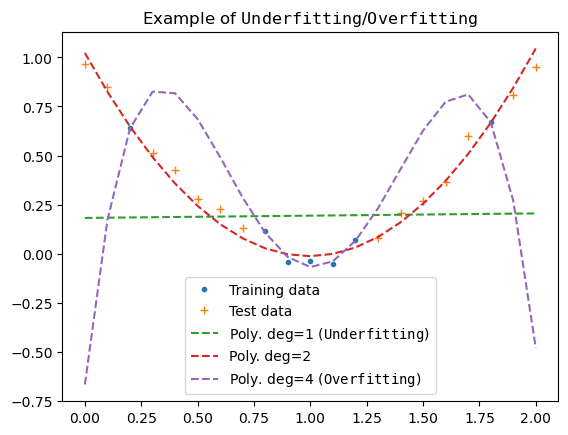

In [26]:
import numpy as np
import numpy.random as rnd
import matplotlib.pyplot as plt

SZ=21
rnd.seed(13)
noise = 0.05*rnd.normal(size=SZ)
ind_train = [2,8,9,10,11,12,18]
ind_test = np.setdiff1d(np.arange(SZ), ind_train)

x = np.linspace(0.,2.0,21)
y = x**2 -2*x + 1 + noise
# Create training and testing set
x_train = x[ind_train]
y_train = x_train**2 -2*x_train +1 + noise[ind_train]
x_test = x[ind_test]
y_test = x_test**2 -2*x_test +1 + noise[ind_test]

# Fit sel. points to polynomials of a order 1,2 and 4
coeffs1 = np.polyfit(x_train, y_train, 1)
p1 = np.poly1d(coeffs1)
y1 = p1(x)

coeffs2 = np.polyfit(x_train, y_train, 2)
p2 = np.poly1d(coeffs2)
y2 = p2(x)

coeffs4 = np.polyfit(x_train, y_train, 4)
p4 = np.poly1d(coeffs4)
y4 = p4(x)

plt.plot(x_train, y_train, '.', label="Training data")
plt.plot(x_test, y_test, '+', label="Test data")
plt.plot(x, y1, '--', label="Poly. deg=1 ("+r"$\mathtt{Underfitting}$"+")")
plt.plot(x, y2, '--', label="Poly. deg=2")
plt.plot(x, y4, '--', label="Poly. deg=4 ("+r"$\mathtt{Overfitting}$"+")" )
plt.title(r"Example of $\mathtt{Underfitting}$/$\mathtt{Overfitting}$")
plt.legend()
plt.show()

## 9.3.Hints to develop neural nets 

* <font color="green"><b>Algorithm</b></font>:<br>
  $\texttt{Start with simple model}$<br>
  
  $\texttt{while(Bias == High)}$<br>
  $\texttt{\{}$<br>
     $\hspace{0.35in}\texttt{Reduce High Bias}$<br>
  $\texttt{\}}$<br>

  $\texttt{while(Variance==High)}$<br>
  $\texttt{\{}$<br>
     $\hspace{0.35in}\texttt{Reduce High Variance}$<br>
  $\texttt{\}}$<br>
    
* How to deal with High Bias and Variance?
  - <font color="red"><b>High Bias</b></font> ($\Rightarrow$ training model needs improvement)
    * increase the number of <font color="green"><b>hidden layers</b></font>
    * increase the number of <font color="green"><b>units per layer</b></font>
    * increase the number of <font color="green"><b>epochs</b></font> 
    * may have to change <font color="green"><b>NN architecture</b></font>
  - <font color="red"><b>High Variance</b></font> (your model does not work well at crosss-validation)
    * use <font color="green"><b>regularization</b></font> to reduce overfitting.
    * may have to <font color="green"><b>increase the training data</b></font> to have a more versatile model.<br>
      <font color="orangered"><b>Note:</b></font><br>
      The technique of <a href="https://en.wikipedia.org/wiki/Data_augmentation"><b>data augmentation</b></a> may be an option.<br>
      + images: rotation, flipping, cropping, filtering, ...
      + audio: adding noise, shifting pitch, (in/de)crease speed, ...
    

## 9.4.Hyper parameters

* Deep Learning has a <font color="green"><b>lot of hyperparameters</b></font>
  + learning rate ($\alpha$), learning rate decay
  + momentum terms: $\beta_1$, $\beta_2$
  + $L$, $n^{[l]}$ for $l \in \{1,2, \ldots, L\}$
  + $m$ (Size of the mini-batch)
  + ...
* <font color="green"><b>Importance</b></font>: (in descending order)<br>
  $\alpha$ > $\beta_1$, $\beta_2$ > $m$ > $n^{[l]}$ > $L$
* How to <font color="green"><b>optimize</b></font> the hyper parameters:
  - Avoid a grid (curse of combinatorics)
  - Choose first random values (cfr. Monte-Carlo vs. trapezoid integration)
  - Then focus on smaller areas

# 10.Improvements

- **Regularization**<br>
  Aim: to deal with <font color="red"><b>overfitting</b></font>/<font color="red"><b>high variance</b></font><br>
  There are several approaches:

  * **Using an additional regularization term**<br>
    Append a <font color="green"><b>regularization term</b></font> ($\mathcal{R}$) to the Cost function, i.e.<br>
    $\begin{eqnarray}
    \mathcal{C} & := & \frac{1}{m} \sum_{i=1}^m \mathcal{L}^{(i)} + \mathcal{R}
 \end{eqnarray}$
    - $\texttt{L}^2$ regularization ($\texttt{Ridge}$ or $\texttt{Tikhonov}$ regularization):<br>
      $\begin{eqnarray}
        \mathcal{R} &:= & \displaystyle \frac{\lambda_2}{2m} \sum_{l=1}^L \sum_{i=1}^{n^{[l-1]}} \sum_{j=1}^{n^{[l]}} \Big(W^{[l]}_{i,j} \Big)^2 \nonumber \\
                    & = & \displaystyle \frac{\lambda_2}{2m} \sum_{l=1}^L  \left\| W^{[l]}\right\|^2_F 
       \end{eqnarray}$<br>
      where $\left\| W^{[l]}\right\|^2_F$ stands for the <a href="https://mathworld.wolfram.com/FrobeniusNorm.html">$\texttt{Frobenius}$</a> norm of the matrix $W^{[l]}$.<br>
      <font color="orangered"><b>Effect</b></font>: <font color="teal"><b>discourages large weights</b></font><br>
      Original paper by *Krogh and Hertz (1991)*:<br>
      <a href="https://proceedings.neurips.cc/paper_files/paper/1991/file/8eefcfdf5990e441f0fb6f3fad709e21-Paper.pdf"><b>A Simple Weight Decay Can Improve Generalization</b></a>
    - $\texttt{L}^1$ regularization ($\texttt{Lasso}$ regularization):<br>
      $\begin{eqnarray}
        \mathcal{R} &:= & \frac{\lambda_1}{m} \sum_{l=1}^L \sum_{i=1}^{n^{[l-1]}} \sum_{j=1}^{n^{[l]}} |W^{[l]}_{i,j}|
       \end{eqnarray}$<br>
      <font color="orangered"><b>Effect</b></font>: <font color="teal"><b>drives less important weights to zero</b></font> i.e. induces sparsity/feature selection.<br>
      Original paper by *Tibshirani (1996)*:<br>
      <a href="https://arindam.cs.illinois.edu/courses/s14cs598/paper/lasso.pdf"><b>Regression Shrinkage and Selection via the Lasso</b></a>
    - $\texttt{Elastic}$ net: combination of $\texttt{L}^1$ and $\texttt{L}^2$ regularization (see <a href="https://www.stat.purdue.edu/~tlzhang/mathstat/ElasticNet.pdf"><b>here</b></a> for the details).<br>
      $\begin{eqnarray}
        \mathcal{R} &:= & \frac{\lambda_1}{m} \sum_{l=1}^L \sum_{i=1}^{n^{[l-1]}} \sum_{j=1}^{n^{[l]}}|W^{[l]}_{i,j}| + \frac{\lambda_2}{2m}  \sum_{l=1}^L \sum_{i=1}^{n^{[l-1]}} \sum_{j=1}^{n^{[l]}}(W^{[l]}_{i,j})^2 
       \end{eqnarray}$

  * **Dropout**
    - How: <font color="green"><b>turn off</b></font> activations <font color="green"><b>randomly</b></font>.
    - Original paper by *Srivastava, Hinton, et al.*:<br> <a href="https://www.cs.toronto.edu/~rsalakhu/papers/srivastava14a.pdf"><b>Dropout: A Simple Way to Prevent Neural Networks from Overfitting</b></font>
    - In essence an <font color="green"><b>adaptive</b></font> version of $\texttt{L}^2$ regularization (reduce weights) 
    - Algorithm ($\texttt{Inverted drop-out}$)
      + For each layer $l$:
        + Set $p^{[l]}$: probability to <font color="green"><b>keep</b></font> activation for layer $l$
        + Calculate $A^{[l]}$ (as in the regular/non-dropout case)
        + Generate a <font color="green"><b>masking matrix</b></font> $M^{[l]} \in \mathbb{R}^{m \times n^{[l]}}$
          * Sample the elements of $M^{[l]}$ from $U(0,1)$ 
          * $
                M^{[l]}_{i,j} = \begin{cases}
                             1, \hspace{0.25in}\texttt{for}\;\;\; M^{[l]}_{i,j} \leq p^{[l]} \\
                             0, \hspace{0.25in}\texttt{for}\;\;\; p^{[l]} \lt M^{[l]}_{i,j} 
                \end{cases}$
        + Use $M^{[l]}$ to <font color="green"><b>discard</b></font> some of the activations in $A^{[l]}$:<br>
          $\begin{eqnarray}
            A^{[l]} &= & A^{[l]} \odot M^{[l]}
           \end{eqnarray}$
        + <font color="green"><b>Rescale</b></font> $A^{[l]}$ (to correct for the missing activations):<br>
          $\begin{eqnarray}
             A^{[l]} & = & \frac{ A^{[l]}}{p^{[l]}}
           \end{eqnarray}$
    - Very popular in the field of computer vision (always a shortage of data $\Rightarrow$ <font color="teal"><b>overfitting).

                
- **Batch Normalization**

  Above we described the <font color="green"><b>standardization/normalization</b></font> of the inputs to speed up the optimization.<br>    The application of the normalization method to the hidden layers is known as <font color="green"><b>batch normalization</b></font>.

  <font color="orangered"><b>Still to be worked further out in the coming days.</b></font>

  Source:<br>
  <a href="https://arxiv.org/pdf/1502.03167"><b><it>Sergey Ioffe and Christian Szegedy (2015)</it>.<br>Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift</b></a>
  

    

<font color="teal"><b>Note (for sake of completeness)</b></font><br>
 <details>
   <summary>Click here to expand!</summary>
   - If $\texttt{L}^{1}$, $\texttt{L}^{2}$ or $\texttt{elastic net}$ regularization is to be used,<br> 
     the gradient term needs to be <font color="green"><b>altered</b></font>: <br>

     * $\texttt{L}^{2}$ regularization:<br>
       $\begin{eqnarray}
         dW^{[l]} & = & dW^{[l]} \,+\,\frac{\lambda_2}{m} W^{[l]},\;\;\;\texttt{for}\,\,\,l \in \{1,2,\ldots,L\}
         \end{eqnarray}$
            
     * $\texttt{L}^{1}$ regularization:<br>
           $\begin{eqnarray}
            dW^{[l]} & = & dW^{[l]} \,+ \,\frac{\lambda_1}{m} \texttt{sgn}(W^{[l]}),\;\;\;\texttt{for}\,\,\,l \in                 \{1,2,\ldots,L\}
            \end{eqnarray}$

     * $\texttt{Elastic}$ net regularization:<br>
           $\begin{eqnarray}
             dW^{[l]} & = & dW^{[l]} \,+ \,\frac{1}{m} \Big [ \lambda_1\,\texttt{sgn}(W^{[l]})\, + \,\lambda_2  W^{[l]}\Big],\;\;\;\texttt{for}\,\,\,l \in                 \{1,2,\ldots,L\}
            \end{eqnarray}
           $

   - If $\texttt{dropout}$ is used, the backpropagation step needs<br> to be <font color="green"><b>altered</b></font> in the following way:<br>
     * <font color="green"><b>Switch off</b></font> those gradients of which the activations
       were switched off during the forward propagation step.<br>
       $\begin{eqnarray}  
        dA^{[l]} & = &  dA^{[l]} \odot M^{[l]},\;\;\;\texttt{for}\,\,\,l \in \{1,2,\ldots,L\}
        \end{eqnarray}$
     * <font color="green"><b>Rescale</b></font> the gradients<br>
       $\begin{eqnarray}  
        dA^{[l]} & = &  \frac{dA^{[l]}}{p^{[l]}},\;\;\;\texttt{for}\,\,\,l \in \{1,2,\ldots,L\}
        \end{eqnarray}$
   
 </details>

# 11.Debugging
The <font color="green"><b>following algorithm</b></font> (based on the <font color="teal"><b>numerical calculation</b></font> of the partial derivatives<br>
of the weights and biases w.r.t. the cost function ($\mathcal{C}$)) should be used iff:<br>
- you write your own code
- and want to check/debug it.

It should <font color="red"><b>NOT</b></font> be used to perform regular training (<font color="red"><b>too expensive</b></font>).<br>
For some background on numerical differentiation, please have a look <a href="./finitediff.ipynb"><b>here</b></a>.
  

$\texttt{Algorithm}$:
- $\texttt{Flatten your weight and bias vectors into one large vector }$ $\Xi$:<br>
  $\begin{eqnarray}
    \Xi & := \begin{pmatrix} w^{[1]}_{1,1} \\
                            w^{[1]}_{2,1} \\
                             \vdots \\
                            w^{[L]}_{n^{[L-1]},n^{[L]}} \\
                            b^{[1]}_1 \\
                            b^{[1]}_2 \\
                             \vdots \\
                             b^{[L]}_{n^{[L]}}
            \end{pmatrix}                           
  \end{eqnarray}$
- Let:
  * $\epsilon$ be very small ($10^{-8}, 10^{-7}$)
  * $\texttt{num\_param} := |\Xi|$ (length of the vector $|\Xi|$)
- 
$\texttt{for(i=1, ..., num\_param)}$<br>
    $\texttt{do}$<br>
       $\begin{eqnarray}
       \;\;\;\;\;d\xi_i & = & \displaystyle \frac{\mathcal{C}(\xi_1,\xi_2,\ldots,\xi_i+ \epsilon,\ldots, \xi_{|\Xi|-1},  \xi_{|\Xi|}) - 
                              \mathcal{C}(\xi_1,\xi_2,\ldots,\xi_i- \epsilon,\ldots, \xi_{|\Xi|-1}, \xi_{|\Xi|})}{2\epsilon} \\
        \;\;\;\;\;\xi_i  & = &   \xi_i \, - \, \alpha \, d\xi_i                    
        \end{eqnarray}$
         
    $\texttt{done}$<br>
